<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scaling Up to 101 Image Classes from Food101

In [1]:
#Check to see if we're using a GPU
!nvidia-smi

Tue Jul 19 22:31:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-19 22:31:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-19 22:31:34 (72.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#importing helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##101 food classes: working with less data

In [4]:
#downloading data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-07-19 22:31:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  90.9MB/s    in 17s     

2022-07-19 22:31:54 (90.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
#how many image classses are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in 

In [7]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (244, 244)


train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#training our big model on 10 percent of food 101

In [8]:
#create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

In [9]:
#Create data augmentation layer to incorprorate right into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#set up data aug
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescale(1/255.) dont need to, already rescaled in efficient net
], name="data_augmentation")

In [10]:
#set up base model and freeze all base model layers (to start)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#set up model architecture with trainable top layers
inputs = layers.Input(shape=(244,244,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #weights in base model stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 244, 244, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
#compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 116s 418ms/step - loss: 3.4541 - accuracy: 0.2524 - val_loss: 2.6599 - val_accuracy: 0.3896
Epoch 2/5
237/237 [==============================] - 74s 311ms/step - loss: 2.3283 - accuracy: 0.4694 - val_loss: 2.1789 - val_accuracy: 0.4807
Epoch 3/5
237/237 [==============================] - 68s 285ms/step - loss: 1.9409 - accuracy: 0.5358 - val_loss: 2.0414 - val_accuracy: 0.4926
Epoch 4/5
237/237 [==============================] - 62s 260ms/step - loss: 1.7339 - accuracy: 0.5805 - val_loss: 1.9605 - val_accuracy: 0.5029
Epoch 5/5
237/237 [==============================] - 59s 249ms/step - loss: 1.5733 - accuracy: 0.6106 - val_loss: 1.9123 - val_accuracy: 0.5040


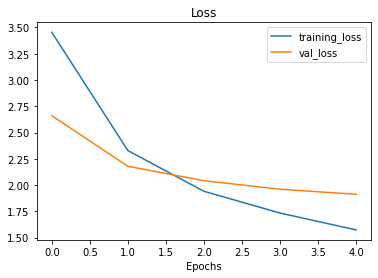

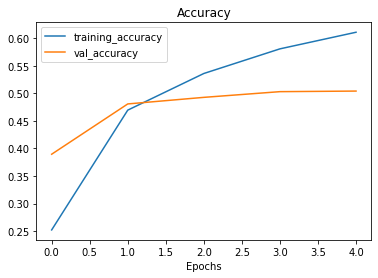

In [13]:
plot_loss_curves(history_all_classes_10_percent)

##fine Tuning

In [14]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
#recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [18]:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [19]:
fine_tune_epochs = 10 #total num of epochs = initial + fine tuning

#fine tuning our model
history_all_classes_10_percent_fine_tuning = model.fit(train_data_all_10_percent,
                                                       epochs=fine_tune_epochs,
                                                       validation_data=test_data,
                                                       validation_steps=int(0.15 * len(test_data)),
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1],)


Epoch 5/10
237/237 [==============================] - 66s 242ms/step - loss: 1.3224 - accuracy: 0.6606 - val_loss: 1.8651 - val_accuracy: 0.5175
Epoch 6/10
237/237 [==============================] - 54s 226ms/step - loss: 1.1950 - accuracy: 0.6874 - val_loss: 1.8519 - val_accuracy: 0.5246
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.1226 - accuracy: 0.7061 - val_loss: 1.8400 - val_accuracy: 0.5265
Epoch 8/10
237/237 [==============================] - 51s 213ms/step - loss: 1.0495 - accuracy: 0.7245 - val_loss: 1.8540 - val_accuracy: 0.5172
Epoch 9/10
237/237 [==============================] - 50s 211ms/step - loss: 0.9792 - accuracy: 0.7419 - val_loss: 1.8128 - val_accuracy: 0.5302
Epoch 10/10
237/237 [==============================] - 46s 194ms/step - loss: 0.9359 - accuracy: 0.7526 - val_loss: 1.8116 - val_accuracy: 0.5302


In [20]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 66s 84ms/step - loss: 1.5184 - accuracy: 0.6005


[1.518412470817566, 0.6004752516746521]

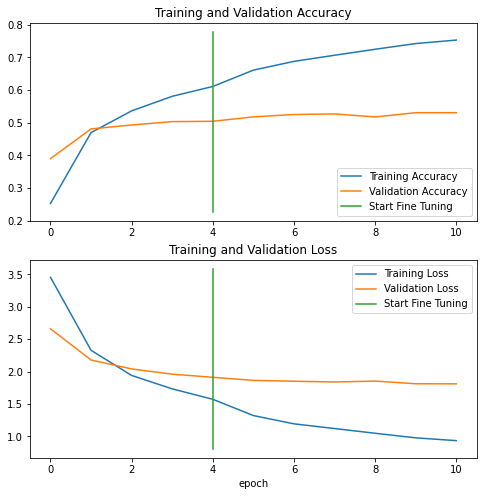

In [21]:
#compare historys
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tuning)

In [22]:
#Saving and Loading our trained model
model.save("101_food_classes_10_percent_saved_big_model_fine_tuned")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_model_fine_tuned/assets


In [4]:
import tensorflow as tf
load_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_model_fine_tuned")

OSError: ignored

In [ ]:
loaded_models_results = load_model.evaluate(test_data)
loaded_models_results
all_classes_10_percent_fine_tune_results

#making predictions iwth trained model

In [ ]:
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

In [ ]:
len(test_data)

In [ ]:
len(pred_probs)

In [ ]:
#Shape of predicitions
pred_probs.shape

In [ ]:
#first 10 predictions
pred_probs[:10]

In [ ]:
#first predicition
pred_probs[0]

In [ ]:
len(pred_probs[0])

In [ ]:
print(f"Number of predicition probabilites for sample 0: {len(pred_probs[0])}")
print(f"What preidcition probability sample 0 looks like: {pred_probs[0]}")
print(f"best predicited probability of sample 0: {pred_probs[0].argmax()}")

In [ ]:
test_data.class_names[0]

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
#how many pred classes
len(pred_classes)

#compare predicitions array to original test data labels


In [ ]:
#unraveling test_data BatchDataset
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

#Evaluating the models predictions

In [ ]:
#checking order of pred vs. test data
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

In [ ]:
import numpy as np
np.isclose(all_classes_10_percent_fine_tune_results, sklearn_accuracy)

In [ ]:
class_names = test_data.class_names
#making a confusion matrix 
#visualizing with helper fucntions
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

#classification reports for other metrics on predictions

In [ ]:
#SciKitLearn classification metrics (precision, recall, F1)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                            y_pred=pred_classes, output_dict=True)
classification_report_dict

In [ ]:
class_names

In [ ]:
class_names[70]

In [ ]:
#create empty dictionary
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [ ]:
class_f1_scores

In [ ]:
#Turning f1 scores into a dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [ ]:
f1_scores

In [ ]:
f1_scores[:10]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.invert_yaxis()


In [ ]:
#creating a function to load and prepare imagres
def load_and_prep_image(filename, img_shape=244, scale=True):
  """
  Reads in file anmea nd preps image
  """
  #rading in image
  img = tf.io.read_file(filename)

  #decodee imag ein to tensor
  img = tf.io.decode_image(img, channels=3)

  #resize
  img = tf.image.resize(img, [img_shape, img_shape])

  #scale
  if(scale):
    #rescale
    return img/255.
  else:
    return img

In [ ]:
#making predictiions on series of rnadom images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  print(pred_prob)
  print(pred_class)

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if(class_name == pred_class):
    title_color="g"
  else:
    title_color="r"

  plt.title(f"acutal:{class_name}, pred: {pred_class}, prob: {pred_prob.argmax()}", c=title_color)
  plt.axis(False)

#Finidng most wrong predictions

In [ ]:
##using list_files() method
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filespaths[:10]

In [5]:
import pandas as pd
pred_df = pd.DataFram({"img_path": filepahts,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": pred_probs.max(axis=1),
                       "y_true_classname": [class_names[i] for i in y_labels],
                       "y_pred_classnames": [class_names[i] for i in pred_classes]})
pred_df

AttributeError: ignored

In [6]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

NameError: ignored

In [7]:
pred_df

NameError: ignored

In [8]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong[:20]

NameError: ignored

In [10]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1], scale=False)
  plt.imshow(img/255.)
  _, _, _, _, pred_prob, y_ture_classname, y_pred_classname, _ = row
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \n prob: {pred_prob}")
  plt.axis(False)

NameError: ignored